In [1]:
"""
conda create -n ncbf python=3.10
conda activate ncbf
pip install torch numpy matplotlib tqdm scipy gurobipy
"""

%reload_ext autoreload
%autoreload 2

from ncbf.train_test import (
    collect_ncbf,
    collect_qp,
    test_ncbf,
    test_qp,
    train_ncbf,
    train_qp,
)

import numpy as np
import random
import torch

args = {}
args["random_seed"] = 42
args["device"] = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(args["random_seed"])
np.random.seed(args["random_seed"])
torch.manual_seed(args["random_seed"])
np.set_printoptions(precision=2, suppress=True)

In [2]:
"""Do rollouts of a nominal policy to collect safety information."""
args["max_agent_vel"] = 2
args["world_dims"] = [0, 100]
args["rollouts"] = 100
args["steps_per_rollout"] = 50
args["render"] = False
    
rollout_data = collect_ncbf(args)

100%|██████████| 100/100 [00:00<00:00, 524.88it/s]


In [3]:
"""Train a NN to predict future max violations."""
args["num_epochs"] = 100
args["learning_rate"] = 1e-4
args["hidden_dims"] = [256, 128, 64, 32]

ncbf_model = train_ncbf(args, rollout_data)

[100/100] | Loss: 0.0116: 100%|██████████| 100/100 [00:01<00:00, 58.46it/s]


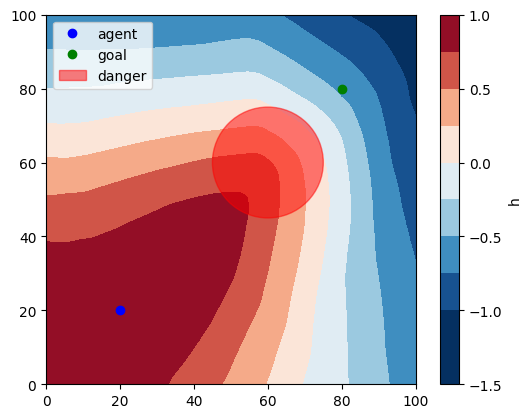

In [4]:
"""Plot the NCBF against agent position."""
args["contour_grid_size"] = 100
args["contour_levels"] = 8

test_ncbf(args, ncbf_model)

In [5]:
"""Use the NCBF model and QP to generate safe trajectories."""
args["rollouts"] = 500
args["steps_per_rollout"] = 50
args["render"] = False

qp_data = collect_qp(args, ncbf_model)

100%|██████████| 500/500 [01:57<00:00,  4.26it/s]


In [6]:
"""Train a NN to match the QP solutions."""
args["num_epochs"] = 2000
args["learning_rate"] = 1e-4
args["hidden_dims"] = [256, 128, 64, 32]

qp_model = train_qp(args, qp_data)

[2000/2000] | Loss: 0.0024: 100%|██████████| 2000/2000 [04:09<00:00,  8.03it/s]


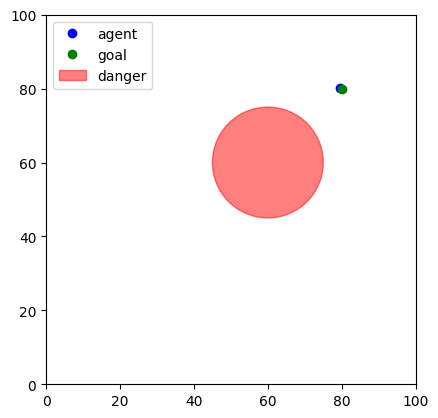

State array:
[79.64 80.1   0.    0.   80.   80.    0.    0.   60.   60.    0.    0.  ]
h: -0.5566
action: [0.06 0.01]


In [9]:
"""Render the policy using the QP model."""
args["rollouts"] = 3
args["steps_per_rollout"] = 75

_ = test_qp(args, qp_model)

In [8]:
# Test the QP solver here
from ncbf.filter import QPFilter
from ncbf.state import State

s = State()
f = QPFilter(args, ncbf_model)

# Choose a custom state and nominal action
s.agent_pos = np.array([25, 25])
u_nominal = np.array([1, 1])

f(s, u_nominal)

array([ 0.  , 70.13])